In [5]:
import gdal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#my code
from raster_sample import *
from profile_map_scanner import *




In [14]:
#send pd dataframe to csv for plotting in arc

creek= "Cache_creek_clip_MChiSegmented_whole_basin.csv"
read_path = "/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Cache_creek/"+creek#+"/" #Set path to data
#Creek name for M_chi segmented files
creek_data = np.genfromtxt((read_path), delimiter=',', skip_header=1, names=['node','row','col','latitude','longitude','chi','elevation','flow_distance','drainage_area','m_chi','b_chi','source_key','basin_key','segmented_elevation'])
#+name])
#+name
creek_data_df = pd.DataFrame(creek_data)
#convert to UTM
creek_data_df = convert_lat_long(creek_data_df)

pd.set_option('display.float_format', lambda x: '%.3f' % x)#remove scientific notation !!!!!
creek_data_df

write_path = '/Users/bmelosh/Documents/ArcGIS/Coast_Ranges/Cache_Creek/'
creek_data_df.to_csv('Cache_creek_m_chi.csv')



In [681]:
#Import the RASTER data
raster_path = "/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Cache_creek/"
raster = gdal.Open(raster_path + "/Cache_creek_clip_HS.bil")#Get raster data
dem = raster.ReadAsArray()

## IMPORT point DATA
creek= "Crack_canyon"
path = "/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Cache_creek/Previous_LSDTT_version/Channel_extraction/"+creek+"/" #Set path to data
name = creek+"_MChiSegmented.csv" #Set file name
creek_data = np.genfromtxt((path+name), delimiter=',', skip_header=1, names=['node', 'row', 'col', 'latitude', 'longitude', 'chi', 'elevation', 'flow_distance', 'drainage_area', 'm_chi', 'b_chi', 'source_key', 'basin_key', 'segmented_elevation'])


#Create pandas dataframe
creek_data_df = pd.DataFrame(creek_data)

#Create a distance column in pandas dataframe
#distance = creek_data_df['flow_distance'] - creek_data_df['flow_distance'].min()
#creek_data_df['distance'] = distance

#convert the lat long to utm from creek data, chi segmented (only need this if there is no x, y columns)
creek_data_df = convert_lat_long(creek_data_df)



In [678]:
#Create a bokeh plot of the raster
import bokeh.plotting as bp
from bokeh.plotting import figure, show, output_file
from bokeh.layouts import gridplot, column


#pull out the products of raster subsampler
X,Y, array = raster_subsample_xy_generator(raster, creek_data_df)

#Create a bokeh source to use in interactive plots
source=bp.ColumnDataSource(creek_data_df)
color_by_variable('m_chi', source=source) #define color scheme for profiles

#define boundaries of the data
x_range, y_range = define_boundaries(source)
elev_range = define_elevation_boundaries(source)


#Create profile plots 

p = stream_map_raster(array, source, title='Map',x_axis_label='Easting', y_axis_label='Northing')

p2 = profile(elev_range, source, title='Elevation profile', x_axis_label='Distance', y_axis_label='Elevation')

p3 = profile(elev_range, source, x='chi', title='Chi profile', x_axis_label='Chi', y_axis_label='Elevation')


output_file("Profile comparison.html", title="Creek scanner")

plotcol = column(p2, p3)
grid = gridplot([[p, plotcol]])

bp.show(grid)  


NameError: name 'raster_subsample_xy_generator' is not defined

In [6]:

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors



In [7]:
#IMPORT MOVERN FILE WITH ALL THE DIFFERENT CHI VALUES FOR EACH M/N RATIO
creek =  'Perkins_creek'
path = '/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Cache_creek/Previous_LSDTT_version/Channel_extraction/'+creek+'/'
name = creek+'_movern.csv'
#Import Data
creek_movern_df = pd.read_csv((path+name), delimiter=',', header=0, names=['source_key','basin_key','elevation','m_over_n = 0.1','m_over_n = 0.2','m_over_n = 0.3','m_over_n = 0.4','m_over_n = 0.5','m_over_n = 0.6','m_over_n = 0.7','m_over_n = 0.8'])

creek_movern_df = creek_movern_df.rename(columns={'source_key': 'Tributary'})

#THIS SEPERATES OUT THE TRIBUTARY DATA
#creating dataframe of CHI data for all tributaries
creek_movern_df_tributaries = creek_movern_df[creek_movern_df['Tributary'] != 0]

creek_movern_tributaries_merge = pd.DataFrame()



In [3]:
#THIS LOADS THE MLE DATA FOR EACH M/N VALUE FOR EACH TRIBUTARY 

mle_data_i = []
chiMS = []
chi = []
TributariesMLE = []

#Create array of mn values to iterate through (start_mn, end_mn, number of mn values)
mn_values = [x / 10.0 for x in range(1, 9, 1)]#create a list of floats.


for mn in mn_values: 
    num = mn
    full_name = '%s%s_movernstats_%s_fullstats.csv' % (path, creek, num)

    name_mle = 'MLE m/n %s' % num
    name_rmse = 'RMSE m/n %s' % num

    mle_data = pd.read_csv(full_name, delimiter=',', header= 0,names=['basin_key', 'reference_source_key', 'test_source_key','MLE','RMSE'])

    mle_data = pd.DataFrame(mle_data)
    mle_data_i.append(mle_data)

    creek_movern_tributaries_merge_i = creek_movern_df_tributaries.merge(mle_data, left_on = "Tributary", right_on = "test_source_key")
            
    creek_movern_tributaries_merge[name_mle] = creek_movern_tributaries_merge_i['MLE']
    creek_movern_tributaries_merge[name_rmse] = creek_movern_tributaries_merge_i['RMSE']
    
    
    TributariesMLE_i = list(creek_movern_tributaries_merge[name_mle])
    
    TributariesMLE.append(TributariesMLE_i)
    
    MLE_array = np.asarray(TributariesMLE)
    this_cmap = plt.cm.Reds
    cNorm  = colors.Normalize(vmin=np.min(MLE_array), vmax=np.max(MLE_array))
    plt.cm.ScalarMappable(norm=cNorm, cmap=this_cmap)
    
    #pull out the chi - elevation data for the tributaries
    a = creek_movern_df[creek_movern_df['Tributary']!=0]
    elevation = a['elevation']
    chi_i = list(a['m_over_n = %s' % num])
    elevation = list(elevation)
    chi.append(chi_i)
    
    #pull out the chi - elevation data for the main stem
    b = creek_movern_df[creek_movern_df['Tributary']==0]
    elevationMS = b['elevation']
    chiMS_i = list(b['m_over_n = %s' % num])
    chiMS.append(chiMS_i)
    
    


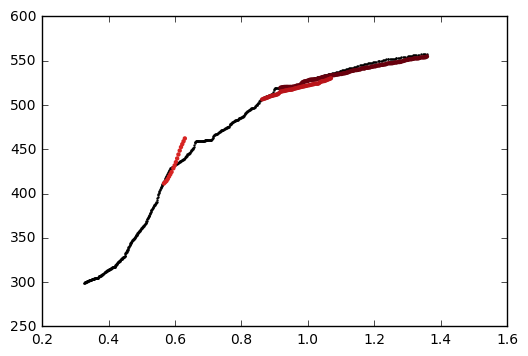

In [5]:
def multiplotter(num):

    plt.scatter(chiMS[num], elevationMS, c='k', s=0.5)
    plt.scatter(chi[num], elevation, c=TributariesMLE[num], cmap=this_cmap, norm=cNorm, s=10, edgecolors='none')

    plt.show()
    
    
multiplotter(5)

##OK this looks like i can do this in mpl now, what about bokeh slider?